In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from sparse_shift.plotting import plot_dag

In [5]:
dag = np.zeros((11, 11))
dag[2, np.asarray([3, 4])] = 1
dag[4, 3] = 1
dag[8, np.asarray([10, 7, 0, 1, 9])] = 1
dag[7, np.asarray([0, 1, 5, 6, 9, 10])] = 1
dag[0, 1] = 1
dag[1, 5] = 1
dag[5, 6] = 1

In [3]:
df1 = pd.read_csv('../data/cytometry/dataset_1.csv')

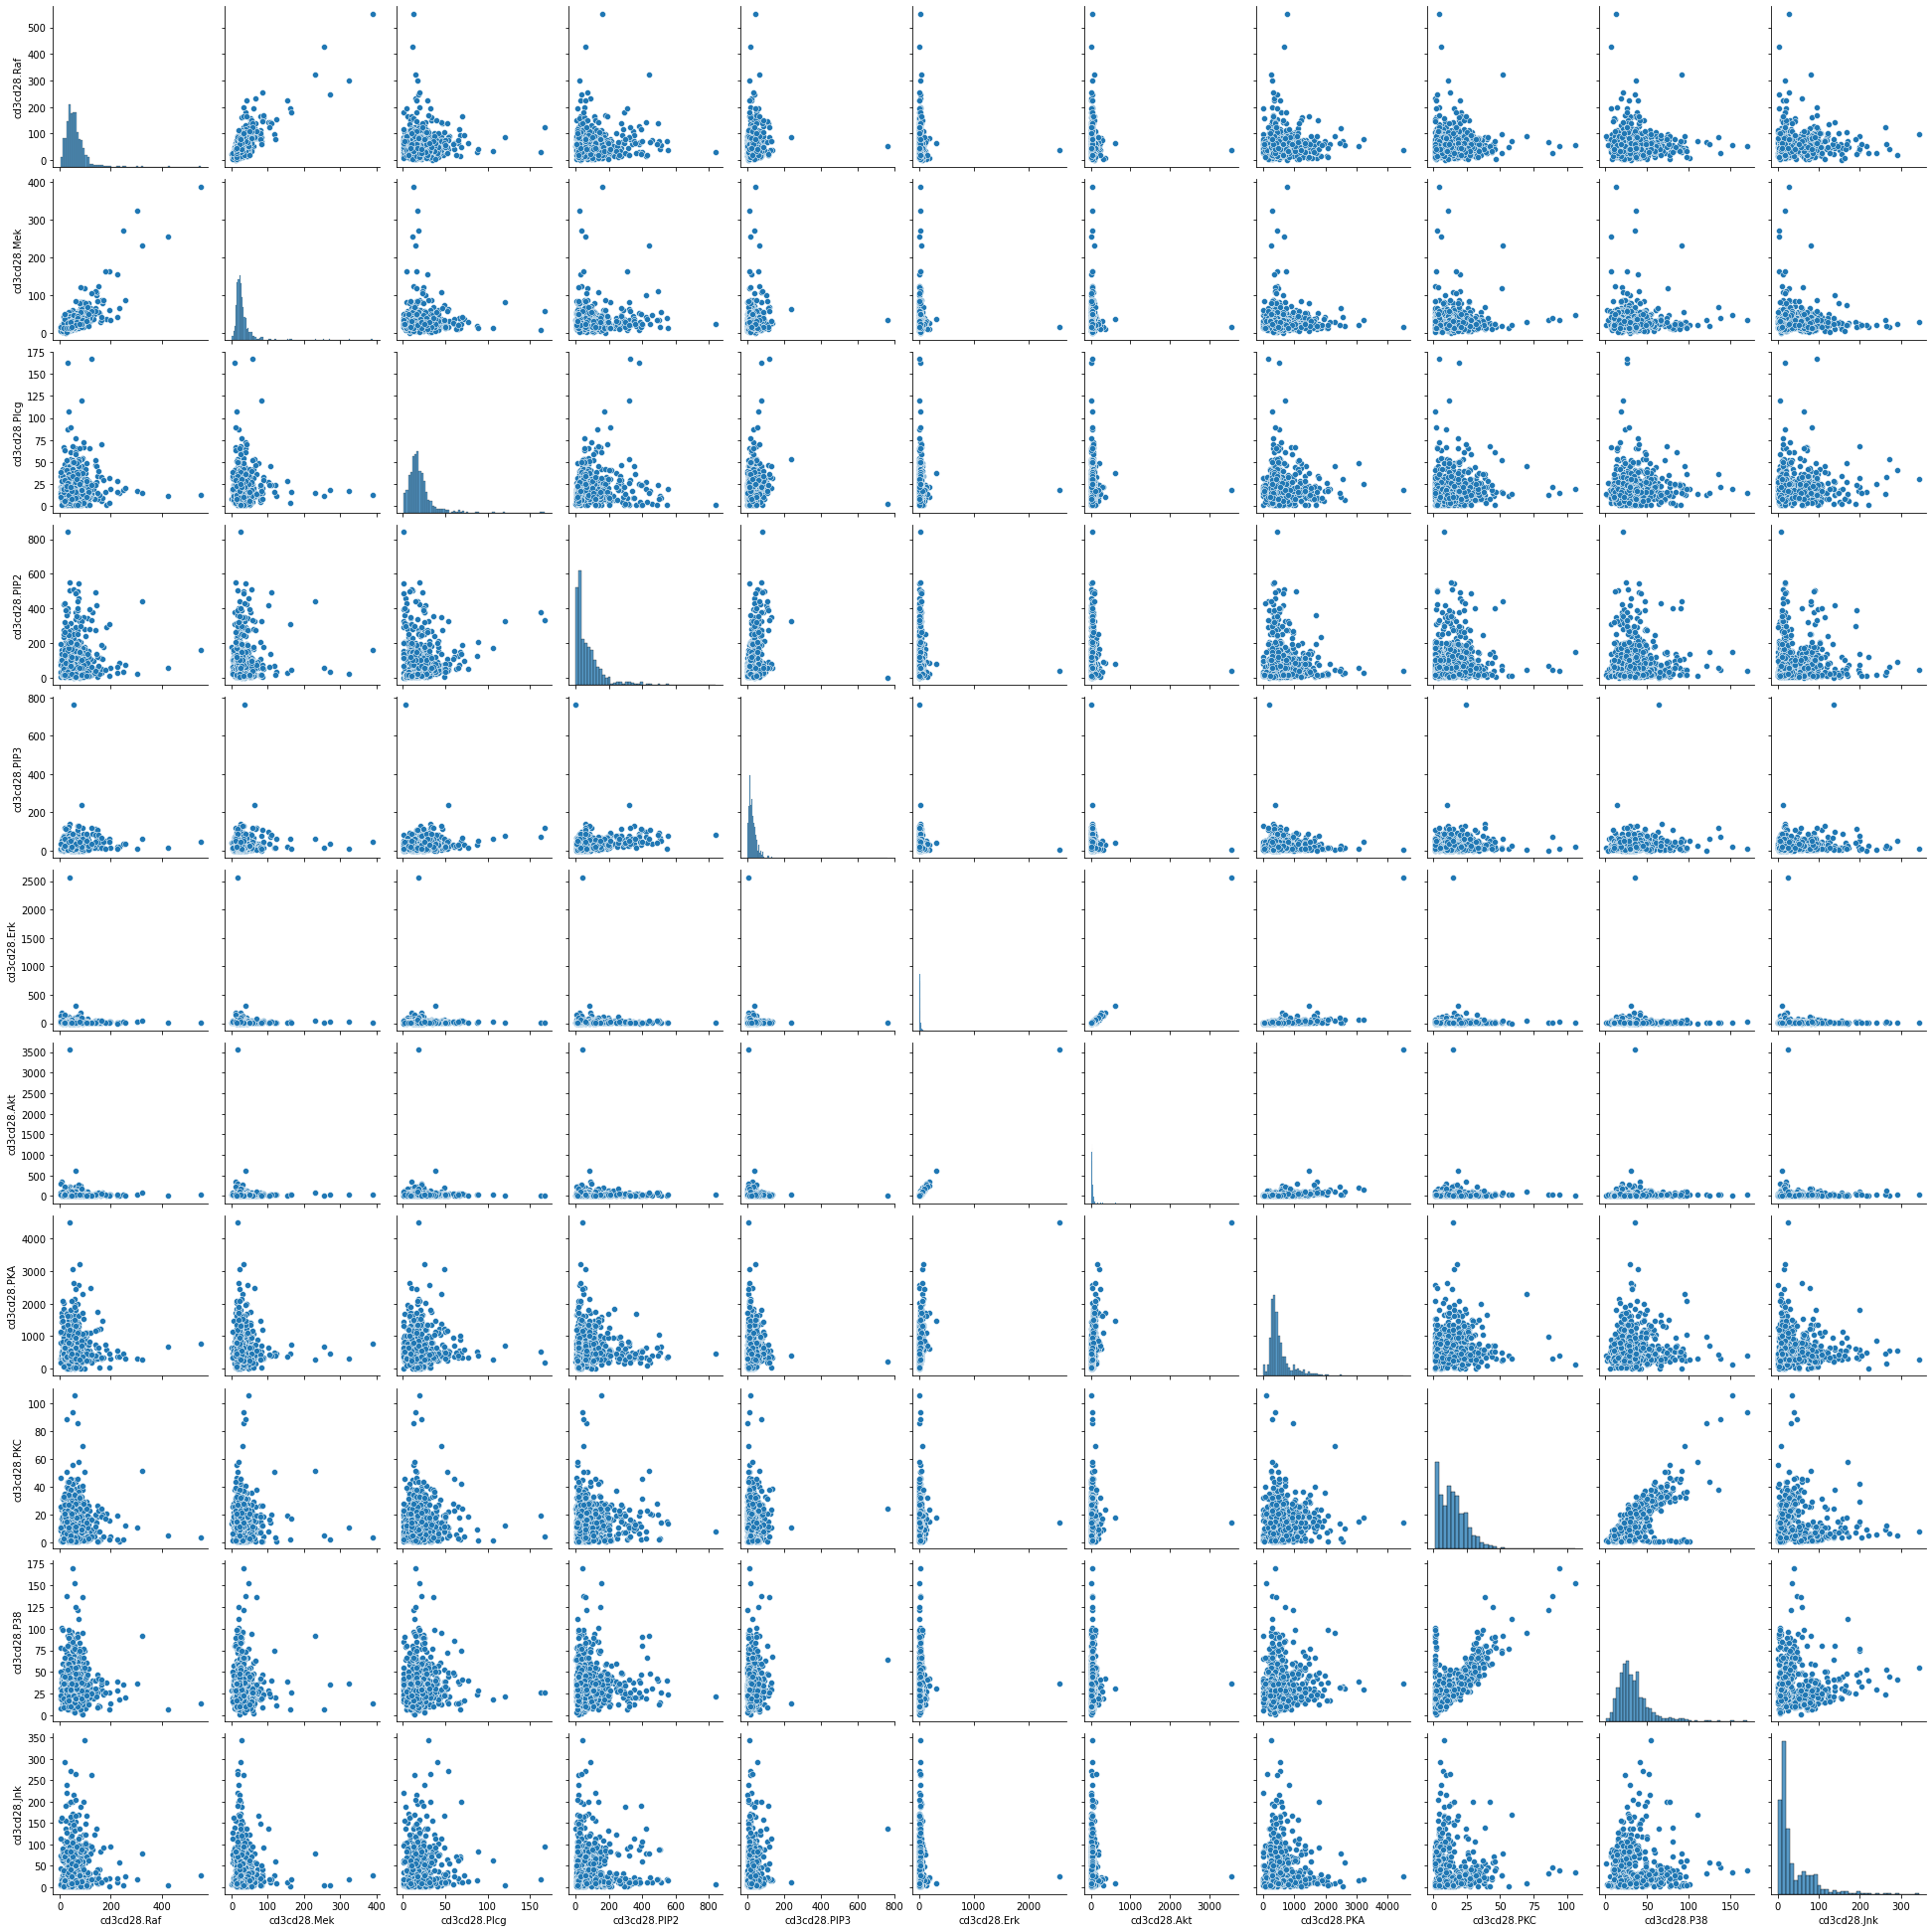

In [12]:
sns.pairplot(df1)

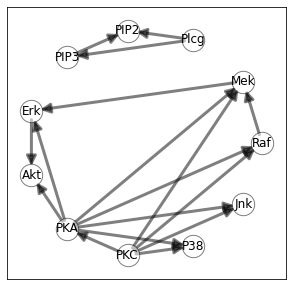

In [9]:
labels = [l.split('.')[1] for l in df1.columns]
plot_dag(dag, labels=labels)

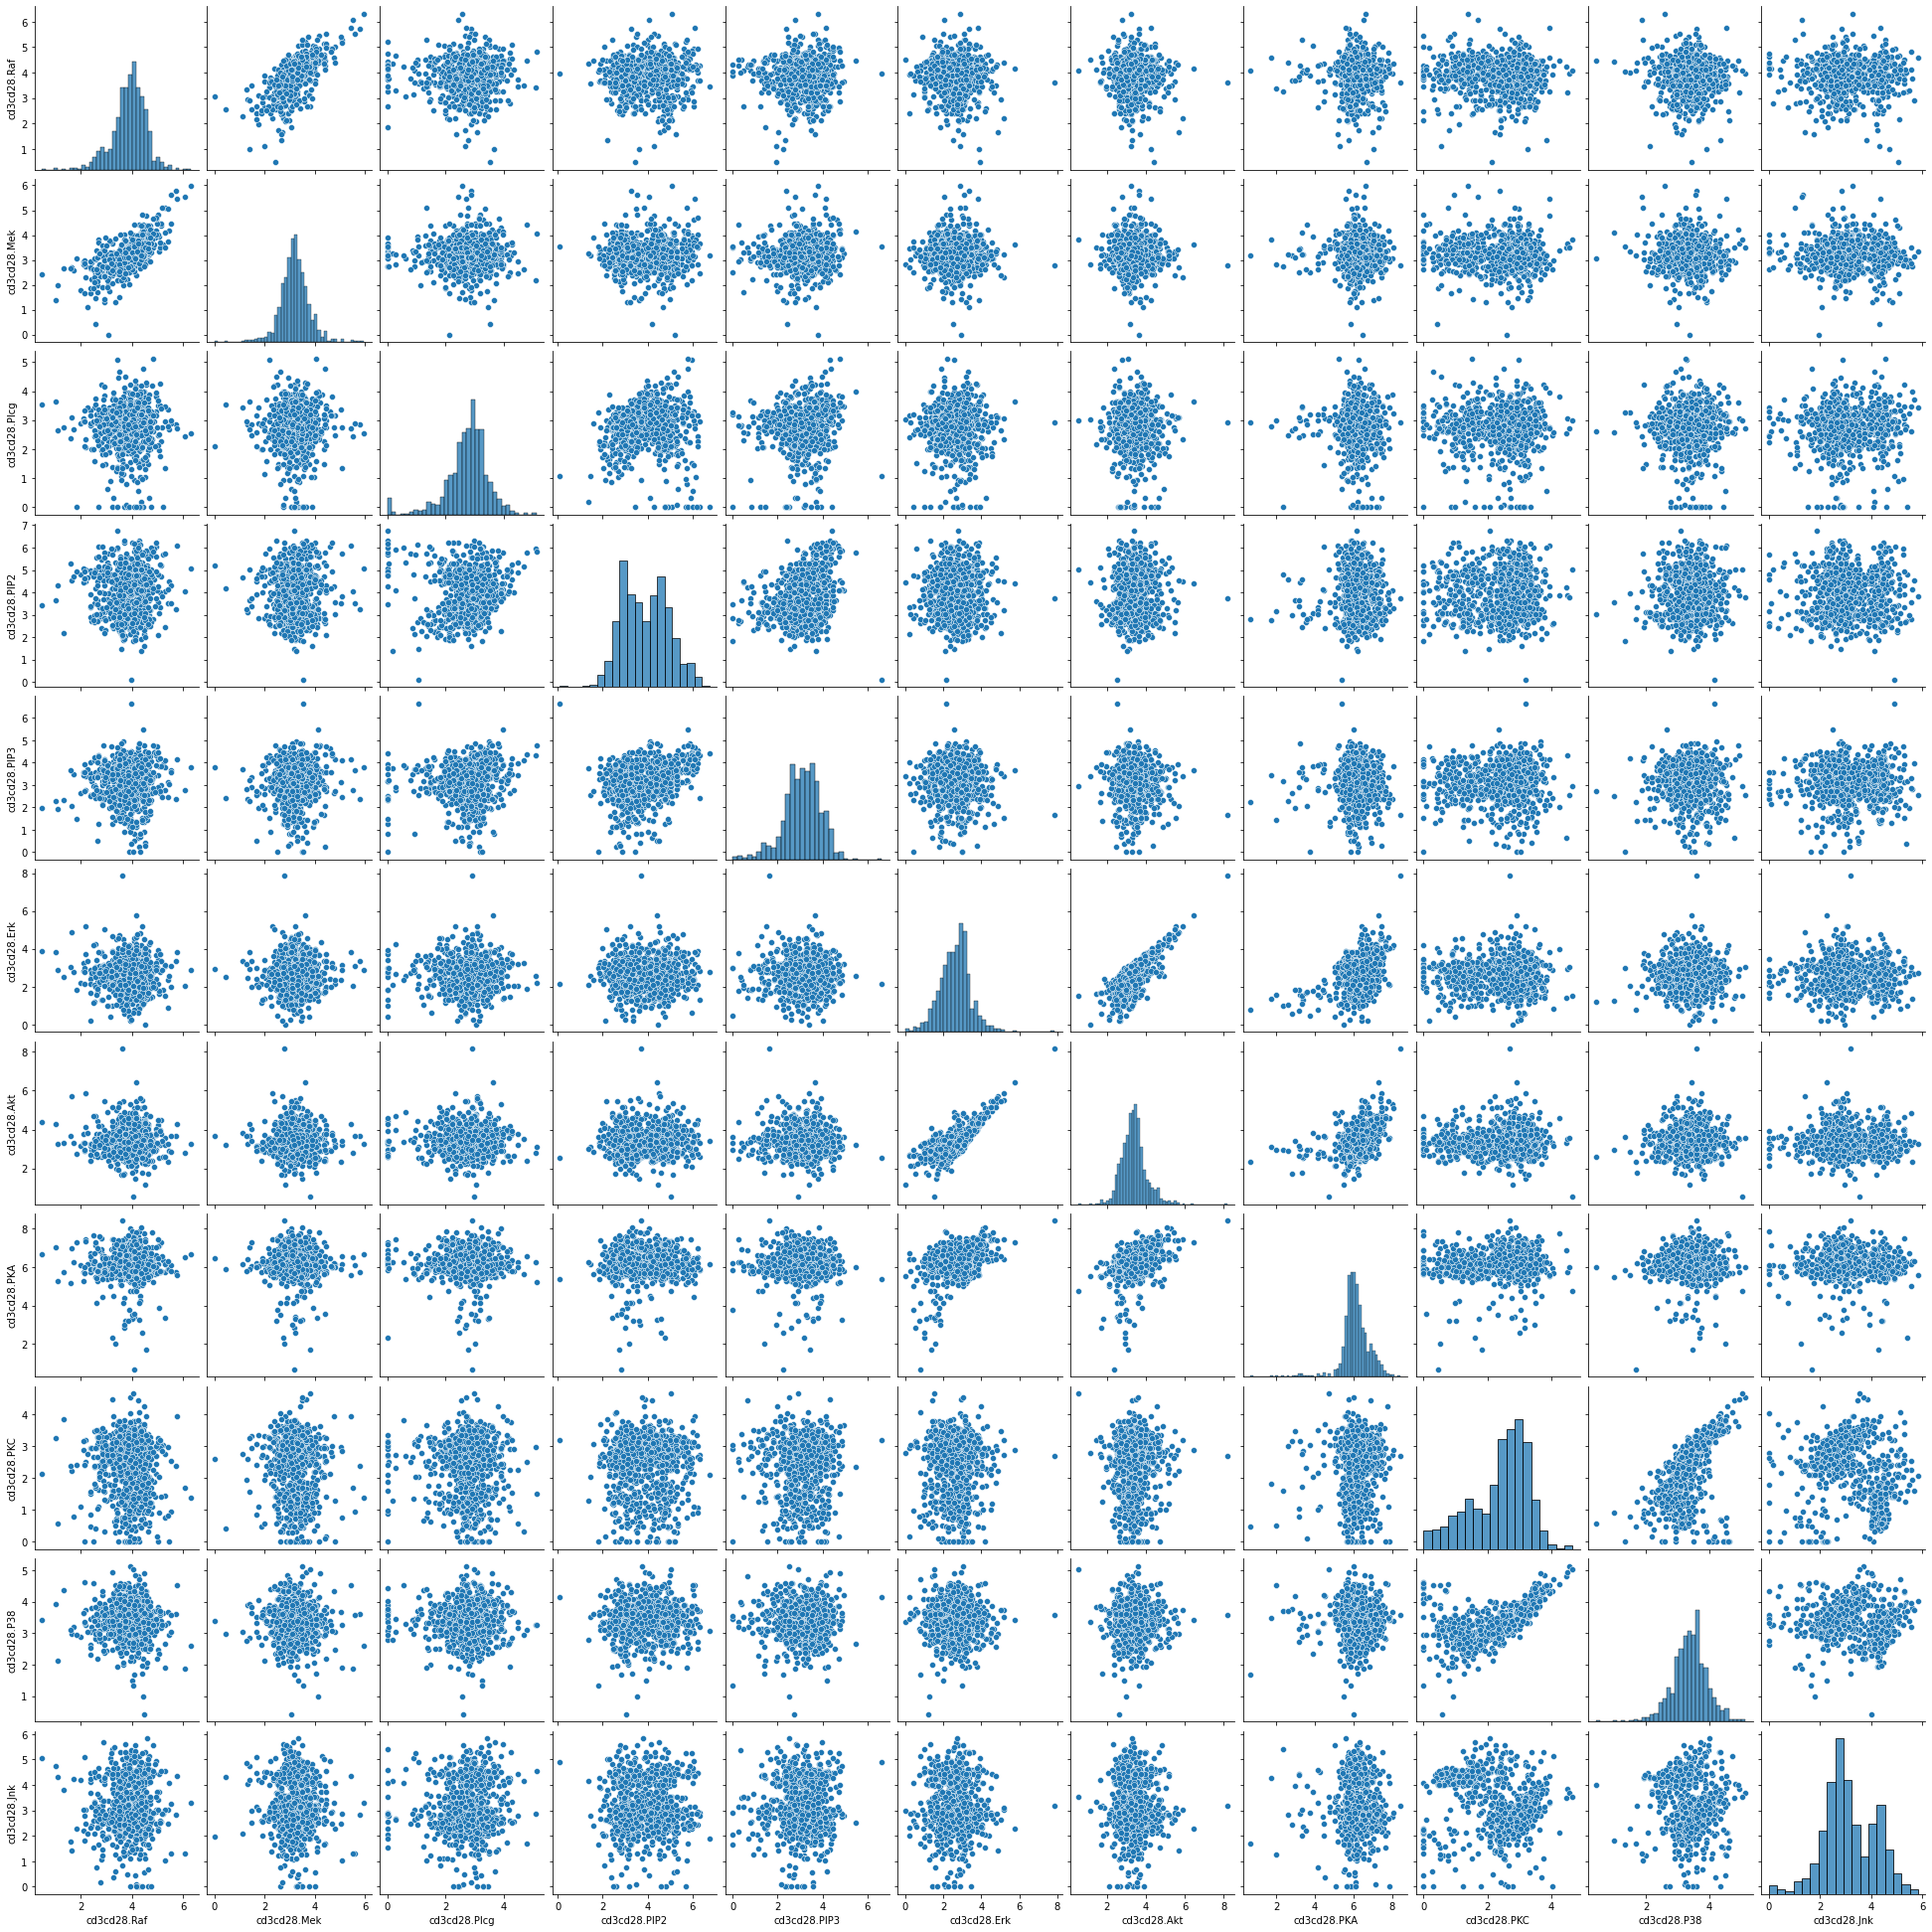

In [13]:
sns.pairplot(np.log(df1))

In [20]:
np.log(df1).to_numpy().shape

(853, 11)

## Run algorithms

In [41]:
from sparse_shift.utils import dag2cpdag, cpdag2dags
from sparse_shift.methods import MinChange, AugmentedPC, FullMinChanges, ParamChanges
from sparse_shift.metrics import dag_true_orientations, dag_false_orientations, \
    dag_precision, dag_recall, average_precision_score

In [16]:
true_dag = dag
true_cpdag = dag2cpdag(true_dag)
mec_size = len(cpdag2dags(true_cpdag))
total_edges = np.sum(true_dag)
unoriented_edges = np.sum((true_cpdag + true_cpdag.T) == 2) // 2

In [35]:
Xs = [
    np.log(
        pd.read_csv(f'../data/cytometry/dataset_{i}.csv')
    ) for i in range(1, 11)
]

In [40]:
METHODS = [
    (
        'mch_kci',
        'Min changes (KCI)',
        MinChange,
        {
            'alpha': 0.05,
            'scale_alpha': True,
            'test': 'kci',
            'test_kwargs': {
                "KernelX": "GaussianKernel",
                "KernelY": "GaussianKernel",
                "KernelZ": "GaussianKernel",
            },
        }
    ),
]

In [43]:
# Compute empirical results
save_name, method_name, mch, hyperparams = METHODS[0]
mch = mch(cpdag=true_cpdag, **hyperparams)
results = []

for n_env, X in enumerate(Xs):
    print(n_env)
    mch.add_environment(X)

    min_cpdag = mch.get_min_cpdag(False)

    true_orients = np.round(dag_true_orientations(true_dag, min_cpdag), 4)
    false_orients = np.round(dag_false_orientations(true_dag, min_cpdag), 4)
    precision = np.round(dag_precision(true_dag, min_cpdag), 4)
    recall = np.round(dag_recall(true_dag, min_cpdag), 4)

    results += [true_orients, false_orients, precision, recall]
    print(precision, recall)

0
1 0.0
1


KeyboardInterrupt: 

In [ ]:
np.save(
    f"./results/pvalue_mats/{name}/{name}_{save_name}_pvalues_params={params_index}_rep={rep}.npy",
    mch.pvalues_,
)